# <center>基于SIFT的图像拼接</center>

## 1、检测关键点和计算关键点描述

In [1]:
import  numpy as np
import cv2
import matplotlib.pyplot as plt

def detectAndDescribe(image):
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 建立SIFT生成器
    descriptor = cv2.SIFT_create()
    # 检测特征点并计算描述子
    kps, features = descriptor.detectAndCompute(gray, None)
    kps = np.float32([kp.pt for kp in kps])
    return kps, features

In [2]:
# 读取图片
imageB = cv2.imread("./img/example1/2.jpg")
imageA = cv2.imread("./img/example1/1.jpg")
# 检测关键点和计算关键点描述
kpsA, featureA = detectAndDescribe(imageA)
kpsB, featureB = detectAndDescribe(imageB)

## 2、匹配两张图片的特征点

In [3]:
def matchKeypoints(kpsA, kpsB, featureA, featureB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.BFMatcher()

        # 使用KNN检测来自AB图的SIFT特征匹配
        rawMatches = matcher.knnMatch(featureA, featureB, 2)

        # 过滤
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算H矩阵
            H, status = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, reprojThresh)

            return matches, H, status

# 绘制匹配结果
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # 初始化可视化图片，将A、B图左右连接到一起
    hA, wA = imageA.shape[:2]
    hB, wB = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:(wA+wB)] = imageB

    # 联合遍历，画出匹配对
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # 当点对匹配成功时，画到可视化图上
        if s == 1:
            # 画出匹配对
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # 返回可视化结果
    return vis

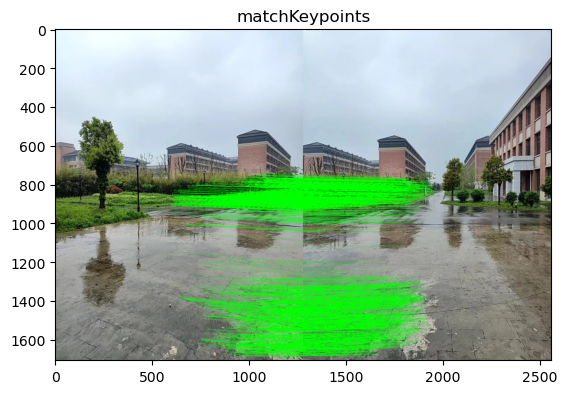

In [4]:
# 匹配两张图片的特征点
M = matchKeypoints(kpsA, kpsB, featureA, featureB, ratio = 0.75, reprojThresh = 4.0)
# 没有匹配点，退出
if not M:
    print('没有匹配点')
else:
    matches, H, status = M
    # 生成匹配图片
    matches = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
    vis = cv2.cvtColor(matches, cv2.COLOR_BGR2RGB)
    plt.title("matchKeypoints")
    plt.imshow(vis), plt.show()

## 3、对右图进行透视变换并拼接左图

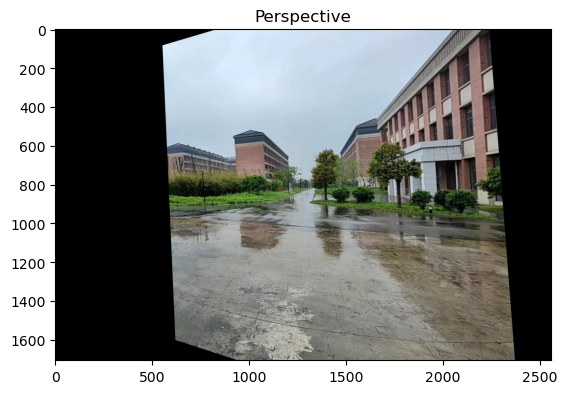

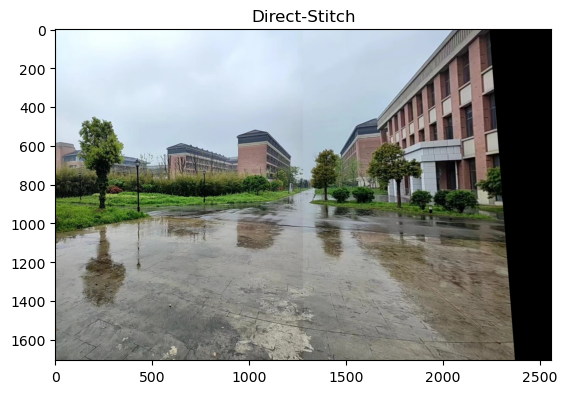

(<matplotlib.image.AxesImage at 0x239b77238b0>, None)

In [5]:
# 将图片B进行透视变换 中间结果
result = cv2.warpPerspective(imageB, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
perspective = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.title("Perspective")
plt.imshow(perspective), plt.show()

# 将图片A传入
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA
direct = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.title("Direct-Stitch")
plt.imshow(direct), plt.show()

## 4、混合渐变拼缝

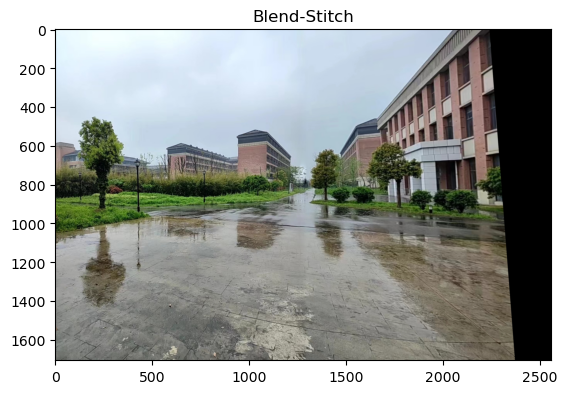

(<matplotlib.image.AxesImage at 0x239b82d2b50>, None)

In [6]:
# 计算混合渐变
mask = np.zeros((imageA.shape[0], imageA.shape[1]), dtype=np.uint8)
mask[:, imageA.shape[1] - 40:] = 255
blend = cv2.seamlessClone(imageA, result, mask, (imageA.shape[1], imageA.shape[0] // 2), cv2.NORMAL_CLONE)
blend_stitch = cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)
plt.title("Blend-Stitch")
plt.imshow(blend_stitch), plt.show()

## 5、完整拼接函数与结果展示

In [7]:
# 拼接函数
def stitch(images, ratio = 0.75, reprojThresh = 4.0):
    # 读取图像
    imageB, imageA = images
    # 计算特征点和特征向量
    kpsA, featureA = detectAndDescribe(imageA)
    kpsB, featureB = detectAndDescribe(imageB)

    # 匹配两张图片的特征点
    M = matchKeypoints(kpsA, kpsB, featureA, featureB, ratio, reprojThresh)

    # 没有匹配点，退出
    if not M:
        return None

    matches, H, status = M
    
    # 生成匹配图片
    matches = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)

    
    # 将图片B进行透视变换 中间结果
    result = cv2.warpPerspective(imageB, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
#     perspective = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
#     plt.title("Perspective")
#     plt.imshow(perspective), plt.show()
    
    # 将图片A传入
    result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA
#     direct = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
#     plt.title("Direct-Stitch")
#     plt.imshow(direct), plt.show()

    # 计算混合渐变
    mask = np.zeros((imageA.shape[0], imageA.shape[1]), dtype=np.uint8)
    mask[:, imageA.shape[1] - 40:] = 255
    blend = cv2.seamlessClone(imageA, result, mask, (imageA.shape[1], imageA.shape[0] // 2), cv2.NORMAL_CLONE)

#     blend_stitch = cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)
#     plt.title("Blend-Stitch")
#     plt.imshow(blend_stitch), plt.show()

    # 返回匹配结果
    return matches, result, blend

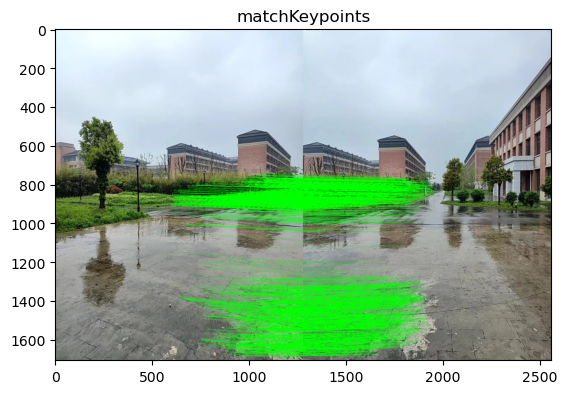

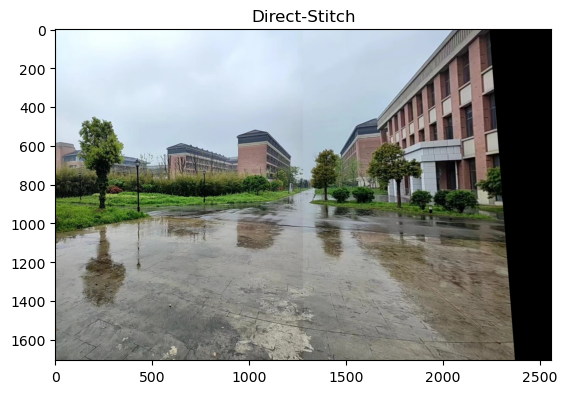

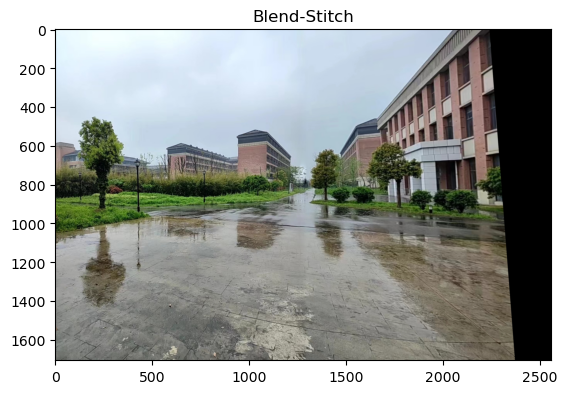

True

In [8]:
imageB = cv2.imread("./img/example1/2.jpg")
imageA = cv2.imread("./img/example1/1.jpg")

matches, result, blend = stitch([imageB, imageA])

vis = cv2.cvtColor(matches, cv2.COLOR_BGR2RGB)
plt.title("matchKeypoints")
plt.imshow(vis), plt.show()
cv2.imwrite('matches.png', matches)

direct = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.title("Direct-Stitch")
plt.imshow(direct), plt.show()
cv2.imwrite('direct.png',  result)

blend_stitch = cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)
plt.title("Blend-Stitch")
plt.imshow(blend_stitch), plt.show()
cv2.imwrite('blend.png', blend)